First lets load our data

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [2]:
# download
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

transform = transforms.ToTensor()
mnist = datasets.MNIST("../../Data",train=True,download=True,transform=transform)

celeb = datasets.CelebA("../../Data",split="train",download=True,transform=transform)


Files already downloaded and verified


In [3]:
# loading data
images = [celeb[i][0] for i in range(10000)]
labels = [celeb[i][1] for i in range(10000)]


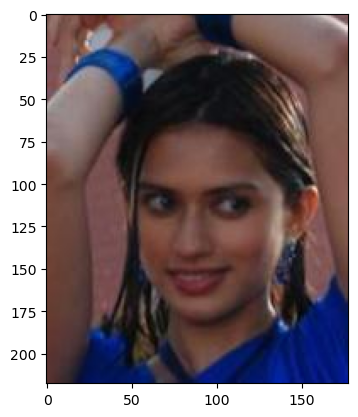

torch.Size([3, 218, 178])


In [4]:
plt.imshow(images[999].permute(1,2,0))
plt.show()
print(images[9000].shape)

## Simple Autencoder

- Lets visualize on this simple dataset the 3D latent-space of a basic (unstructured space) autoencoder

In [5]:
D1 = 218
D2 = 178 # dimensionality of data
import torch.nn as nn
# creating the MLP autoencoder
class AutoencoderMLP(nn.Module):
    def __init__(self):
        super(AutoencoderMLP, self).__init__()
        # data is N,3,1024 (B,Color,Pixels)
        # apply same transformation to each color
        # (processed as a batch dimension)
        self.encoder = nn.Sequential(
            nn.Linear(D1*D2,512), # (B,3,pixels) --> (B,3,nout)
            nn.ReLU(),
            nn.Linear(512,128), # (B,3,prev) --> (B,3,nout)
            nn.ReLU(),
            nn.Linear(128,20),
            nn.ReLU(),
            nn.Linear(20,20), # final latent-space compression
        )

        # reverse of encoder
        self.decoder = nn.Sequential(
            # doesn't need to be symetric
            # just the ability to learn a reconstruction
            nn.Linear(20,20),
            nn.ReLU(),
            nn.Linear(20,128),
            nn.ReLU(),
            nn.Linear(128,512),
            nn.ReLU(),
            nn.Linear(512,D1*D2),
            nn.Sigmoid() # values between 0 and 1
        )


    def forward(self,x):
        x = x.view(-1,3,D2*D1) # batch, 3, 32*32
        x = self.encoder(x) # bottleneck
        x = self.decoder(x) # reconstruction
        return x
    
    def get_latent(self,x):
        x = x.view(-1,D1*D2)
        x = self.encoder(x)
        return x
    
    
autoencoder = AutoencoderMLP()
# moving to GPU
device = 'cuda'
autoencoder.to(device=device)


optimizer = torch.optim.AdamW(autoencoder.parameters(),lr=3e-4,weight_decay=1e-5)

In [6]:
# to generate batches for autoencoder
def get_batch(data,size):
    # return size,3,h*w batches of data
    # data is list of tensors
    ind = torch.randint(0,len(data),size=(size,),device=device).tolist()
    batch = torch.stack([data[i] for i in ind]).to(device=device)
    return batch.view(size,3,D1*D2).to(device)

losses = []

In [7]:
# Training Loop
autoencoder.train()
for i in range(300):
    
    # zero-grad
    optimizer.zero_grad()
    
    # forward pass
    x = get_batch(images,32)
    x_recon = autoencoder(x.clone())
    loss = nn.functional.mse_loss(x_recon,x)
    
    # stepping
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if i %100 == 0:
        print(i," loss: ",loss.item())


0  loss:  0.08339201658964157
100  loss:  0.05587484687566757
200  loss:  0.04406529664993286


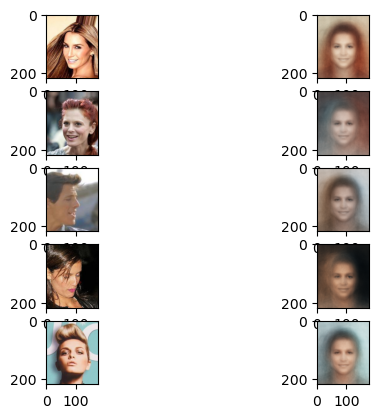

In [8]:
# Evaluating autoencoder
fig,axes = plt.subplots(5,2)


test_imgs = []

with torch.no_grad():
    for i in range(5):
        test_imgs.append(autoencoder(images[i].to(device)).to('cpu').view(3,D1,D2).permute(1,2,0))

for i in range(5):
    axes[i][0].imshow(images[i].permute(1,2,0))
    axes[i][1].imshow(test_imgs[i])

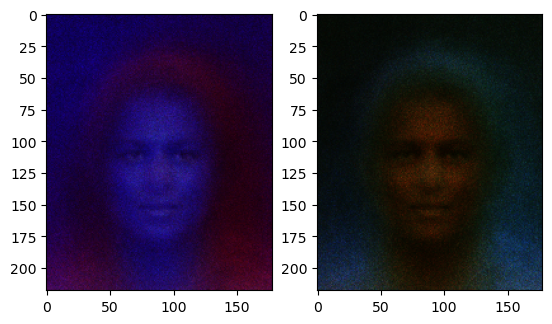

In [9]:
# trying to sample
fig,axes = plt.subplots(1,2)


# we can't sample! no center of data!
# trying to sample latent vars
show = autoencoder.decoder(torch.normal(0,10,size=(3,20),dtype=torch.float32).to(device)).detach().to('cpu').view(3,D1,D2).permute(1,2,0)
show2 = autoencoder.decoder(torch.normal(0,10,size=(3,20),dtype=torch.float32).to(device)).detach().to('cpu').view(3,D1,D2).permute(1,2,0)

# there is no feasable way to interpret our data...

axes[0].imshow(show)
axes[1].imshow(show2)

## VAE
As we see up above, our scale is very large, and if we tried to sample from this latent-space, just as sampling from random pixels, we would have no idea what is more likely for an image, and whether shifting a latent variable will change an image in a meaningful way.

I tried playing around with sampling, but really it just causes arbitrary changes (in R,G, or B)

Having a structured latent-space allows us to actually sample, and infer about what causes what in images! Hence, our VAE motivation

> Notice the gaps in our space, these make it so we can't interpolate between points smoothly
>
> In VAE's, we also may want to, for example, to text-to-image encoding, which would not be possible if we didn't have some 'smoothing' between data

# VAE

The power of VAE's, is they introduce smoothe interpolation through having the models account for probabilities, and introduce forced overlap between different shared features, since the space is somewhat constrained.

Now, we will code a simple varaitional autoencoder, the only differences will be:

1. Our loss will have a 'regularization term' induced by the KL divergence
2. We will create a mu and sigma vector, and be using our reparameterization trick

In [10]:
# scaling images 0 - 1
images = [images[i] * 2 - 1 for i in range(len(images))] # scaling from zero to 1

In [61]:
# importing VAE function 
import train
import importlib
import VAE
importlib.reload(train); importlib.reload(VAE)

# def train_VAE(d1,d2,latent,epochs,batch_size,data,alpha,beta):
# alpha controls percentage of MSE, beta-->KL
# be careful based on latent size of params.
model = train.train_VAE(218,178,50,300,32,images,1,2/50)




KL/MSE ratio:  0.6572926044464111
Epoch 0, loss: 0.6726900935173035
KL/MSE ratio:  0.0325104221701622
Epoch 50, loss: 0.3565564453601837
KL/MSE ratio:  0.1338711827993393
Epoch 100, loss: 0.3617842197418213
KL/MSE ratio:  0.12764763832092285
Epoch 150, loss: 0.3063012659549713
KL/MSE ratio:  0.10227438062429428
Epoch 200, loss: 0.30798661708831787
KL/MSE ratio:  0.13452617824077606
Epoch 250, loss: 0.2740360498428345


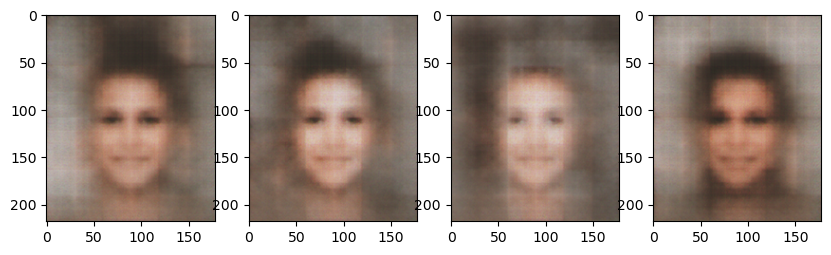

In [63]:
fig, axes = plt.subplots(1,4)
fig.set_size_inches(10,10)

# testing images, need to make sure that they fit desired thing
for i in range(4):
    tst = model.decoder((torch.randn((1,50))).to(device))
    img = (tst.detach().to('cpu').view(3,D1,D2).permute(1,2,0) + 1) / 2
    axes[i].imshow(img)

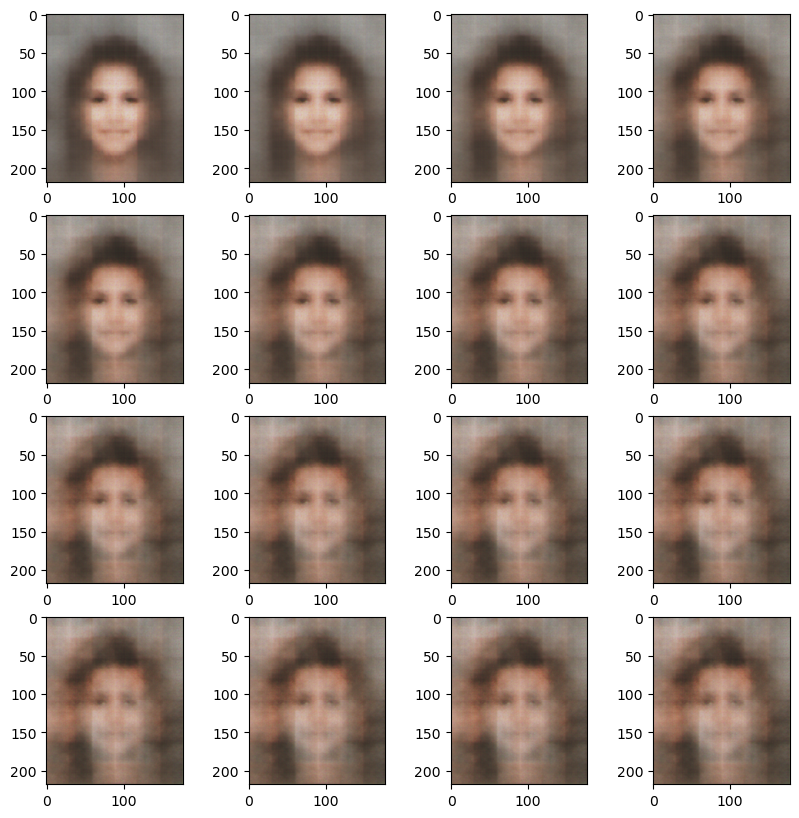

In [64]:
# displaying with adding things...

fig, axes = plt.subplots(4,4)
fig.set_size_inches(10,10)

# testing images, need to make sure that they fit desired thing
for i in range(16):
    tens = torch.zeros(size=(1,50))
    tens[0,3] = i*2
    tst = model.decoder((tens).to(device))
    img = (tst.detach().to('cpu').view(3,D1,D2).permute(1,2,0) + 1) / 2
    axes[int(i/4)][i%4].imshow(img)


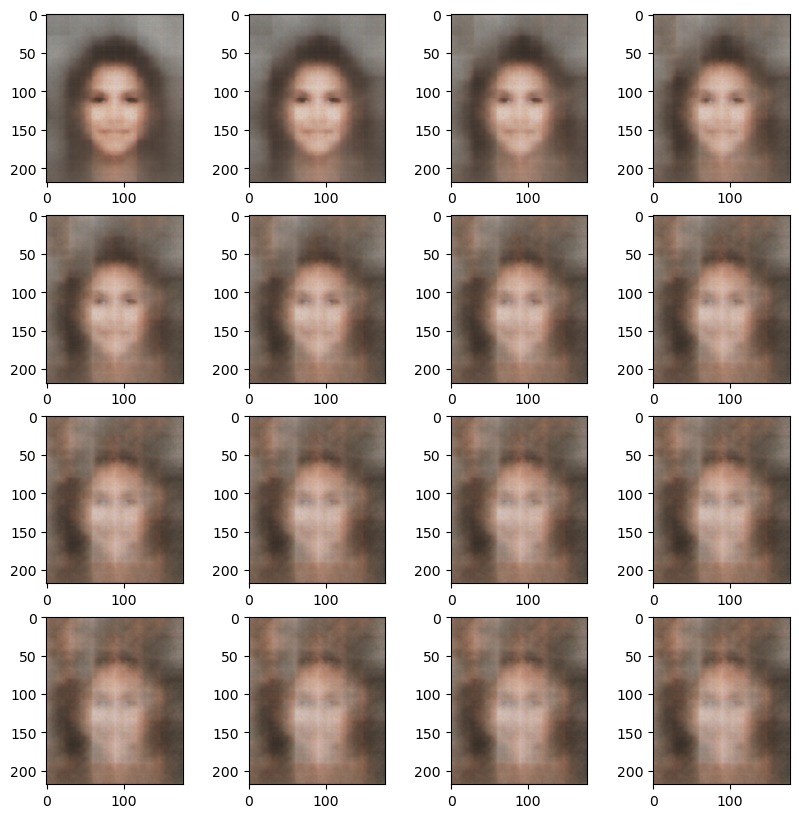

In [65]:
# displaying with adding things...

fig, axes = plt.subplots(4,4)
fig.set_size_inches(10,10)

# testing images, need to make sure that they fit desired thing
for i in range(16):
    tens = torch.zeros(size=(1,50))
    tens[0,6] = i*2
    tst = model.decoder((tens).to(device))
    img = (tst.detach().to('cpu').view(3,D1,D2).permute(1,2,0) + 1) / 2
    axes[int(i/4)][i%4].imshow(img)
